# Projeto da disciplina de Introdução à Ciência de Dados

Estudante: Fernando de Barros (fbwn@cin.ufpe.br)

## Especificação do Projeto 1
1. Coletar Dados
2. Pré-processamento
    1. definição de tipos (pre-proc 1)
    2. tratar dados ausentes (pre-proc 1)
    3. normalização e discretização (pre-proc 1)
    4. limpeza de dados (uni, bi e multivariado)
3. Apresentar Estatisticas descritivas dos dados (com visualizações)
4. Realizar teste de hipótese para comparação de valores de categorias e visualizar diferenças

## TODO List
[ ] Organizar o que já existe para apresentação

[ ] Marcar minhas contribuições

[ ] Listar o que falta para cumprir a especificação

[ ] Deixar a abertura de arquivos mais "clean"

[ ] Deixar a navegação por rows na forma nativa e não via for-index

[ ] Adicionar validação de mínimo de pontos ao final da create_sentences

## Carregamento das Bibliotecas e do Dataset

In [1]:
import math
import sys  
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
from geopy.distance import geodesic


# Sentences
sys.path.insert(0, '../building_trajectories/')
import sentences
#%run '../building_trajectories/sentences.py'

#Spark
import findspark
findspark.init("../venvTraj/lib64/python3.8/site-packages/pyspark/")
from pyspark import SparkContext

# Bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors, OSM, CARTODBPOSITRON, WIKIMEDIA

pd.set_option('display.max_columns', None)

## Inicialização de variaveis para o Bokeh
output_notebook()
tile_provider = OSM
colors=['red','blue', 'black', 'yellow']


Loading BokehJS ...

## Dublin Bus GPS sample data from Dublin City Council (Insight Project)

Bus GPS Data Dublin Bus GPS data across Dublin City, from Dublin **City Council'traffic control**, in csv format. 

Each datapoint (row in the CSV file) has the following entries:

- Timestamp micro since 1970 01 01 00:00:00 GMT  
- Line ID  
- Direction  
- Journey Pattern ID  
- Time Frame (The start date of the production time table - in Dublin the production time table starts at 6am and ends at 3am)  
- Vehicle Journey ID (A given run on the journey pattern)  
- Operator (Bus operator, not the driver)  
- Congestion [0=no,1=yes]  
- Lon WGS84  
- Lat WGS84
- Delay (seconds, negative if bus is ahead of schedule)  
- Block ID (a section ID of the journey pattern)  
- Vehicle ID  
- Stop ID  
- At Stop [0=no,1=yes]

Fonte: https://data.gov.ie/dataset/dublin-bus-gps-sample-data-from-dublin-city-council-insight-project


### Abre arquivo referente aos dias 10~12 de Janeiro de 2013

### Colunas originais do dataset

In [2]:
features = ['timestamp','line_id','direction','journey_id',
            'time_frame','vehicle_journey_id','operator',
            'congestion','lng','lat','delay','block_id',
            'vehicle_id','stop_id', 'stop']

In [3]:
df = pd.read_csv(
    '../data/siri.20130110.csv.gz', 
    compression='gzip', 
    names=features, 
    header=None)
#for i in tqdm(range(20130111,20130112,1)):
#    data = pd.read_csv(
#        '../data/siri.'+str(i)+'.csv.gz', 
#        compression='gzip', 
#        names=features, 
#        header=None)
#    df = pd.concat([df,data])

### Lista com nomes das colunas que formam a chave da trajetória

In [4]:
trajetoria = ['line_id','journey_id','time_frame','vehicle_journey_id','operator','vehicle_id']

In [5]:
df = [x for _,x in df.groupby(trajetoria) if (len(x) > 50)]
df = pd.concat(df)

### Novas features que serão alimentadas junto à criação das trajetórias

In [6]:
df['velocity'] = 0
df['acc'] = 0
df['dist_from_old_point'] = 0
df['time_from_old_point'] = 0


## Análise inicial do dataset

In [7]:
df.head()

,timestamp,line_id,direction,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point
485426,1357813192000000,1.0,0,00010001,2013-01-10,4608,RD,0,-6.262067,53.391167,0,1001,43072,226.0,1,0,0,0,0
486021,1357813208000000,1.0,0,00010001,2013-01-10,4608,RD,0,-6.262084,53.391167,0,1001,43072,226.0,1,0,0,0,0
487232,1357813249000000,1.0,0,00010001,2013-01-10,4608,RD,0,-6.259500,53.391815,0,1001,43072,226.0,1,0,0,0,0
487435,1357813255000000,1.0,0,00010001,2013-01-10,4608,RD,0,-6.259500,53.391815,0,1001,43072,228.0,0,0,0,0,0
487904,1357813270000000,1.0,0,00010001,2013-01-10,4608,RD,0,-6.256383,53.391365,0,1001,43072,228.0,0,0,0,0,0


In [8]:
df.tail()

,timestamp,line_id,direction,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point
1658207,1357859074000000,747.0,0,07471001,2013-01-10,3558,SL,0,-6.299233,53.347218,31,747005,40043,4319.0,1,0,0,0,0
1658518,1357859091000000,747.0,0,07471001,2013-01-10,3558,SL,0,-6.297367,53.346966,31,747005,40043,4319.0,1,0,0,0,0
1659039,1357859130000000,747.0,0,07471001,2013-01-10,3558,SL,0,-6.292050,53.346802,31,747005,40043,4319.0,1,0,0,0,0
1659160,1357859136000000,747.0,0,07471001,2013-01-10,3558,SL,0,-6.292050,53.346802,31,747005,40043,4319.0,1,0,0,0,0
1659459,1357859152000000,747.0,0,07471001,2013-01-10,3558,SL,0,-6.292050,53.346802,31,747005,40043,4319.0,1,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437322 entries, 485426 to 1659459
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   timestamp            1437322 non-null  int64  
 1   line_id              1437322 non-null  float64
 2   direction            1437322 non-null  int64  
 3   journey_id           1437322 non-null  object 
 4   time_frame           1437322 non-null  object 
 5   vehicle_journey_id   1437322 non-null  int64  
 6   operator             1437322 non-null  object 
 7   congestion           1437322 non-null  int64  
 8   lng                  1437322 non-null  float64
 9   lat                  1437322 non-null  float64
 10  delay                1437322 non-null  int64  
 11  block_id             1437322 non-null  int64  
 12  vehicle_id           1437322 non-null  int64  
 13  stop_id              1437322 non-null  float64
 14  stop                 1437322 non-null  int64 

In [10]:
df.describe()

,timestamp,line_id,direction,vehicle_journey_id,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point
count,1.437322e+06,1.437322e+06,1437322.0,1.437322e+06,1.437322e+06,1.437322e+06,1.437322e+06,1.437322e+06,1.437322e+06,1.437322e+06,1.437322e+06,1.437322e+06,1437322.0,1437322.0,1437322.0,1437322.0
mean,1.357828e+15,7.751080e+01,0.0,9.224773e+03,1.308266e-02,-6.270111e+00,5.334335e+01,-6.460931e+01,1.086559e+05,3.539169e+04,2.635274e+03,2.683219e-01,0.0,0.0,0.0,0.0
std,1.716667e+10,1.157860e+02,0.0,7.104796e+04,1.136289e-01,8.202497e-02,5.476866e-02,4.578565e+02,1.924304e+05,3.297149e+03,2.113181e+03,4.430862e-01,0.0,0.0,0.0,0.0
min,1.357776e+15,1.000000e+00,0.0,1.000000e+00,0.000000e+00,-6.615000e+00,5.307038e+01,-7.314000e+03,1.001000e+03,2.804700e+04,2.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
25%,1.357812e+15,1.800000e+01,0.0,2.231000e+03,0.000000e+00,-6.306592e+00,5.331874e+01,-2.710000e+02,1.601600e+04,3.329100e+04,8.120000e+02,0.000000e+00,0.0,0.0,0.0,0.0
50%,1.357828e+15,4.000000e+01,0.0,4.008000e+03,0.000000e+00,-6.261728e+00,5.334589e+01,-2.400000e+01,4.020300e+04,3.351700e+04,2.039000e+03,0.000000e+00,0.0,0.0,0.0,0.0
75%,1.357842e+15,8.300000e+01,0.0,5.625000e+03,0.000000e+00,-6.230950e+00,5.337246e+01,1.100000e+02,8.400300e+04,3.801300e+04,4.319000e+03,1.000000e+00,0.0,0.0,0.0,0.0
max,1.357862e+15,7.470000e+02,0.0,9.997110e+05,1.000000e+00,-6.053083e+00,5.360653e+01,3.300000e+04,8.350020e+05,4.307800e+04,7.552000e+03,1.000000e+00,0.0,0.0,0.0,0.0


Retirar a coluna DIRECTION que não apresenta qualquer informação

In [11]:
df.drop('direction', axis=1, inplace=True)
'direction' in df.columns

False

Indicar quais das colunas são categoricas:

In [12]:
list_cats = ['line_id', 'journey_id' , 'time_frame', 
             'vehicle_journey_id', 'operator', 'block_id', 
             'vehicle_id', 'stop_id']

### Ajusta tipo das features

#### Boolean

In [13]:
df.stop = df.stop.astype('bool')
df.congestion = df.congestion.astype('bool')

#### Datetime (microseconds - us)

In [14]:
df['datetime'] = pd.to_datetime(df["timestamp"], unit='us')

##### Criação de duas novas features derivadas (day, hour)

In [15]:
df['hour'] = df["datetime"].dt.hour
df['day'] = df["datetime"].dt.day

### Categoricos

In [16]:
for cat in list_cats:
    df[cat] = df[cat].astype('category')

### Descrição das chaves para criação de trajetórias

In [17]:
lista_tamanhos = map((lambda x: len(df[x].unique())), trajetoria)
mescla = zip(trajetoria, lista_tamanhos)
print('Descritivo de instâncias únicas para cada atributo da chave:')
tuple(mescla)

Descritivo de instâncias únicas para cada atributo da chave:


(('line_id', 65),
 ('journey_id', 432),
 ('time_frame', 2),
 ('vehicle_journey_id', 7140),
 ('operator', 8),
 ('vehicle_id', 820))

### Como o 'prodution time' é entre 6am e 3am. Existem rotas fora desta janelas?

In [18]:
df[(3 < df.hour) & (df.hour < 6)]

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point,datetime,hour,day


## Gerar trajetórias

Na função que gera trajetórias incluimos algumas features aproveitando o fato de que esta geração de trajetórias percorre o dataset linha a linha, uma vez que precisamos identificar um valor limite entre duas amostras do GPS para poder validar a trajetória. Usamos aqui o valor é de 5 minutos.

In [19]:
gps = ['lat','lng']

def delta_time(t1, t2) -> float:
    ##Return time difference between time in seconds
    t1 = pd.to_datetime(t1,unit='us')
    t2 = pd.to_datetime(t2,unit='us')
    time = pd.Timedelta(np.abs(t2 - t1))
    if (time.seconds > 5*60):
        return np.nan
    else:        
        return time.seconds

def calc_deltas(frame):
    frame.dist_from_old_point = 0
    frame.time_from_old_point = 0
    delta_d = list(map(
        lambda x, y: geodesic(x,y).meters, frame[gps].values[1:], frame[gps].shift(1).values[1:]))
    delta_t = list(map(
        lambda x, y: delta_time(x,y), frame['timestamp'].values[1:], frame['timestamp'].shift(1).values[1:]))
    if (len(frame[frame.isna()]) == 0):
        print('oi')
    frame['dist_from_old_point'] = [0, *delta_d]
    frame['time_from_old_point'] = [0, *delta_t]
    return frame

In [20]:
dfs = [x for _,x in df.groupby(trajetoria) if (len(x) > 50)]
dfs = dfs[:250]
dfs = list(map(calc_deltas,dfs))
dfs = pd.concat(dfs)
#dfs[dfs.time_from_old_point.isna()]

In [21]:
dfs.velocity = dfs.dist_from_old_point / dfs.time_from_old_point
dfs.acc = dfs.velocity * (1/dfs.time_from_old_point)
dfs['acc'].fillna(value=0, inplace=True)
dfs['velocity'].fillna(value=0, inplace=True)

In [22]:
dfs[trajetoria] = dfs[trajetoria].astype('string')
dfs['ID'] = dfs[trajetoria].agg('-'.join, axis=1).astype('category').cat.codes

In [23]:
lista_IDs = dfs[dfs.time_from_old_point.isna()].ID.values
print(lista_IDs)
def index2remove(ID):
    cc = dfs[dfs.ID==ID]
    print(len(cc))
    if (len(cc) ==0):
        return
    cc.sort_values('timestamp')
    ts = cc[cc['time_from_old_point'].isna()].timestamp.values[0]
    if (len(cc[cc.timestamp <= ts]) < 50):
        dfs.drop(cc.index, inplace=True)
        return cc.index
    else:
        dfs.drop(cc[cc.timestamp >= ts].index, inplace=True)
        return cc[cc.timestamp >= ts].index
remover = list(map(index2remove,lista_IDs))

[135 151 155 164 176 200 205 206 208 237 248 248]
187
108
171
173
189
174
188
205
193
66
175
0


In [24]:
lista_IDs = dfs[dfs.time_from_old_point.isna()].ID.values
lista_IDs

array([], dtype=int16)

In [25]:
dfs.head()

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point,datetime,hour,day,ID
485426,1357813192000000,1.0,00010001,2013-01-10,4608,RD,False,-6.262067,53.391167,0,1001,43072,226.0,True,0.000000,0.000000,0.000000,0.0,2013-01-10 10:19:52,10,10,0
486021,1357813208000000,1.0,00010001,2013-01-10,4608,RD,False,-6.262084,53.391167,0,1001,43072,226.0,True,0.070687,0.004418,1.130991,16.0,2013-01-10 10:20:08,10,10,0
487232,1357813249000000,1.0,00010001,2013-01-10,4608,RD,False,-6.259500,53.391815,0,1001,43072,226.0,True,4.546923,0.110901,186.423852,41.0,2013-01-10 10:20:49,10,10,0
487435,1357813255000000,1.0,00010001,2013-01-10,4608,RD,False,-6.259500,53.391815,0,1001,43072,228.0,False,0.000000,0.000000,0.000000,6.0,2013-01-10 10:20:55,10,10,0
487904,1357813270000000,1.0,00010001,2013-01-10,4608,RD,False,-6.256383,53.391365,0,1001,43072,228.0,False,14.222031,0.948135,213.330471,15.0,2013-01-10 10:21:10,10,10,0


## Análisar trajetórias

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437322 entries, 485426 to 1659459
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   timestamp            1437322 non-null  int64         
 1   line_id              1437322 non-null  category      
 2   journey_id           1437322 non-null  category      
 3   time_frame           1437322 non-null  category      
 4   vehicle_journey_id   1437322 non-null  category      
 5   operator             1437322 non-null  category      
 6   congestion           1437322 non-null  bool          
 7   lng                  1437322 non-null  float64       
 8   lat                  1437322 non-null  float64       
 9   delay                1437322 non-null  int64         
 10  block_id             1437322 non-null  category      
 11  vehicle_id           1437322 non-null  category      
 12  stop_id              1437322 non-null  category    

No agrupamento a seguir todas as instâncias com uma das features listadas como chave com valor NaN é descartada.

In [27]:
#backup
df = dfs

In [28]:
df.tail()

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point,datetime,hour,day,ID
1376653,1357844234000000,7.0,00070001,2013-01-10,6048,D1,False,-6.128867,53.246334,-97,7008,43008,4982.0,True,0.054039,0.002573,1.134826,21.0,2013-01-10 18:57:14,18,10,249
1376886,1357844244000000,7.0,00070001,2013-01-10,6048,D1,False,-6.128867,53.246334,-36,7008,43008,4982.0,True,0.000000,0.000000,0.000000,10.0,2013-01-10 18:57:24,18,10,249
1377323,1357844254000000,7.0,00070001,2013-01-10,6048,D1,False,-6.128850,53.246334,-36,7008,43008,4982.0,True,0.113483,0.011348,1.134826,10.0,2013-01-10 18:57:34,18,10,249
1377933,1357844275000000,7.0,00070001,2013-01-10,6048,D1,False,-6.128850,53.246349,-36,7008,43008,4982.0,True,0.079494,0.003785,1.669364,21.0,2013-01-10 18:57:55,18,10,249
1378495,1357844295000000,7.0,00070001,2013-01-10,6048,D1,False,-6.128850,53.246349,-36,7008,43008,4982.0,True,0.000000,0.000000,0.000000,20.0,2013-01-10 18:58:15,18,10,249


In [29]:
new_cols = ['velocity', 'acc', 'time_from_old_point', 'dist_from_old_point',]
            #'MF_velocity', 'MF_acc', 'MF_dist_from_old_point']
df[new_cols].describe()

,velocity,acc,time_from_old_point,dist_from_old_point
count,44351.000000,44351.000000,44351.000000,44351.000000
mean,4.964805,0.376987,20.485806,94.277147
std,15.185035,3.903491,8.519045,182.749141
min,0.000000,0.000000,0.000000,0.000000
25%,0.105728,0.005368,18.000000,2.017425
50%,3.223432,0.152864,20.000000,65.284830
75%,7.178346,0.355361,21.000000,146.276273
max,2327.095588,581.773897,266.000000,10280.014818


<AxesSubplot:>

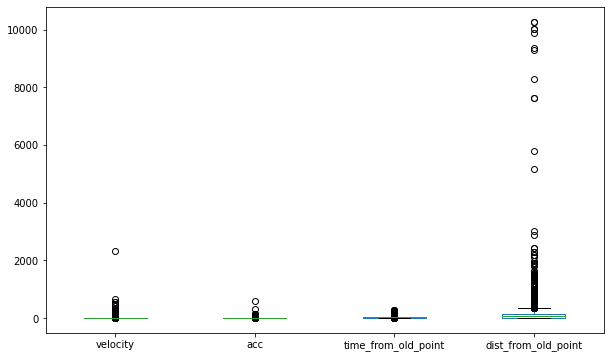

In [30]:
df[new_cols].plot(kind='box', figsize=(10,6))

In [31]:
from sklearn.ensemble import IsolationForest

In [32]:
feats = ['velocity','acc']
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[feats])
scores = clf.predict(df[feats])
df['outlier'] = scores

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[['velocity','acc']]), columns = ['velocity','acc'])
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df_normalized)
scores = clf.predict(df_normalized)
df['outlier_norm'] = scores

In [34]:
df[df.outlier == 1][feats].describe()

,velocity,acc
count,39203.000000,39203.000000
mean,3.301280,0.162733
std,3.287800,0.165670
min,0.000000,0.000000
25%,0.046382,0.001809
50%,2.505812,0.117930
75%,5.811335,0.283757
max,11.662989,0.592866


In [35]:
df[df.outlier_norm== 1][feats].describe()

,velocity,acc
count,39215.000000,39215.000000
mean,3.302338,0.162689
std,3.288347,0.165559
min,0.000000,0.000000
25%,0.046462,0.001814
50%,2.506736,0.118000
75%,5.815046,0.283636
max,11.662989,0.592866


array([[<AxesSubplot:title={'center':'velocity'}>,
        <AxesSubplot:title={'center':'acc'}>]], dtype=object)

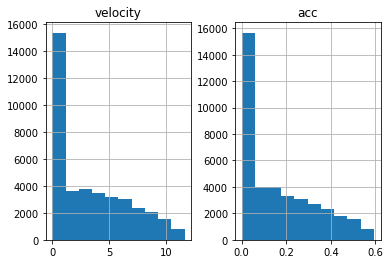

In [36]:
df[df.outlier == 1][feats].hist()

In [37]:
from sklearn.neighbors import LocalOutlierFactor


In [38]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
scores = clf.fit_predict(df[feats])
df['outlier2'] = scores

In [39]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[['velocity','acc']]), columns = ['velocity','acc'])
rng = np.random.RandomState(42)
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
scores = clf.fit_predict(df_normalized)
df['outlier2_norm'] = scores

In [40]:
df[df.outlier2 == 1][feats].describe()

,velocity,acc
count,39916.000000,39916.000000
mean,4.771464,0.329947
std,7.518237,1.861117
min,0.000000,0.000000
25%,0.053980,0.002569
50%,3.212795,0.150982
75%,7.171710,0.351829
max,318.753423,145.281259


In [41]:
df[df.outlier2_norm == 1][feats].describe()

,velocity,acc
count,39916.000000,39916.000000
mean,4.733670,0.318137
std,6.516447,1.517191
min,0.000000,0.000000
25%,0.054086,0.002565
50%,3.316676,0.156636
75%,7.263830,0.359387
max,137.397606,58.823058


In [42]:
df1 = df[df.outlier==1]

In [43]:
df1.drop(['outlier', 'outlier2','outlier_norm','outlier2_norm','day','stop_id','block_id', 'delay'],axis=1,inplace=True)

/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
df1.describe()

,timestamp,lng,lat,velocity,acc,dist_from_old_point,time_from_old_point,hour,ID
count,3.920300e+04,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000
mean,1.357827e+15,-6.234905,53.345443,3.301280,0.162733,69.076827,20.688723,13.797413,131.747137
std,1.660926e+10,0.037985,0.035239,3.287800,0.165670,70.440729,7.259633,4.623869,71.275868
min,1.357798e+15,-6.278733,53.246265,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
25%,1.357813e+15,-6.262819,53.324760,0.046382,0.001809,0.990630,19.000000,10.000000,73.000000
50%,1.357827e+15,-6.250288,53.345348,2.505812,0.117930,51.071739,20.000000,14.000000,136.000000
75%,1.357841e+15,-6.213769,53.367535,5.811335,0.283757,120.651787,21.000000,18.000000,194.000000
max,1.357862e+15,-6.128100,53.418232,11.662989,0.592866,855.211803,266.000000,23.000000,249.000000


<AxesSubplot:>

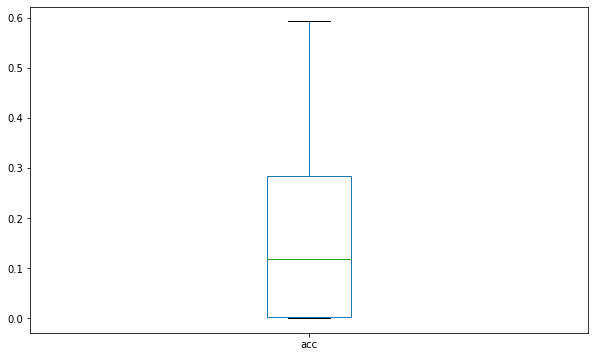

In [45]:
df1['acc'].plot(kind='box', figsize=(10,6))

<AxesSubplot:>

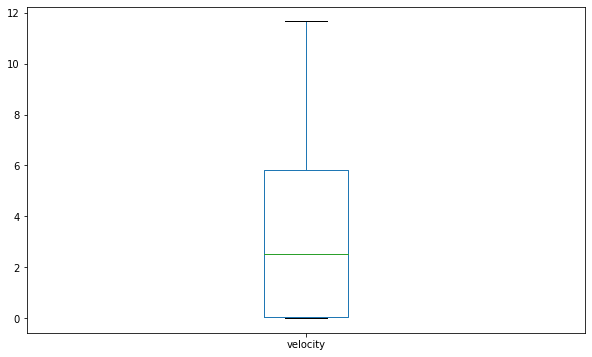

In [46]:
df1['velocity'].plot(kind='box', figsize=(10,6))

<AxesSubplot:>

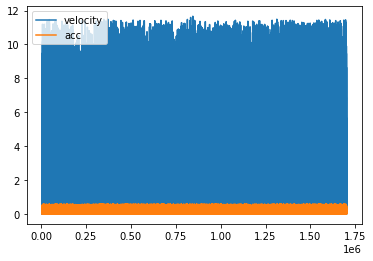

In [47]:
df1[feats].plot()

In [48]:
import seaborn as sns                                              

<AxesSubplot:xlabel='velocity', ylabel='Count'>

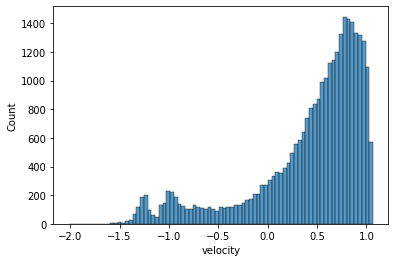

In [49]:
sns.histplot(x=df1[df1.velocity!=0].velocity.apply(np.log10))

<AxesSubplot:xlabel='acc', ylabel='Count'>

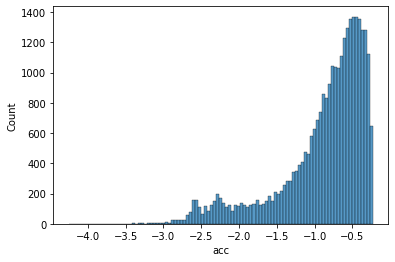

In [50]:
sns.histplot(x=df1[df1.acc!=0].acc.apply(np.log10))

## Teste de Hipótese

### Há diferença na distribuição da velocidade e acelaração no pontos capturados antes e depois do meio-dia?

In [51]:
from scipy import stats

<AxesSubplot:>

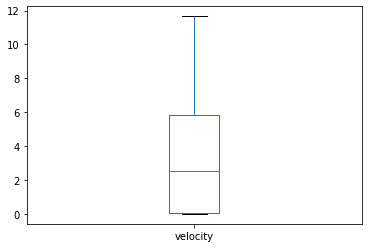

In [52]:
df1.velocity.plot(kind='box', )

<AxesSubplot:>

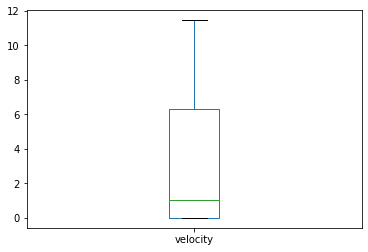

In [53]:
df1[df1.hour > 22].velocity.plot(kind='box')

In [54]:
m = df1.velocity.median()

In [55]:
stats.wilcoxon(df1[df1.hour > 22].velocity - m, alternative='greater')

WilcoxonResult(statistic=295854.0, pvalue=4.6245915756000885e-05)

In [56]:
lh_vel = []
lh_acc = []
hours = df1.hour.unique()
for h in hours:
        lh_vel.append(stats.mannwhitneyu(df1[df1.hour <= h].velocity, df1[df1.hour > h].velocity)[1])
        lh_acc.append(stats.mannwhitneyu(df1[df1.hour <= h].acc, df1[df1.hour > h].acc)[1])

/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


<AxesSubplot:>

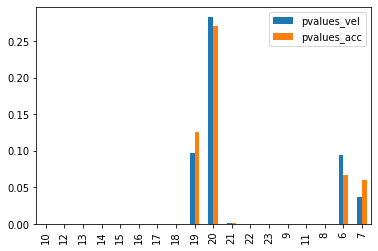

In [57]:
pd.DataFrame(data={'pvalues_vel':lh_vel, 'pvalues_acc':lh_acc}, index=hours).plot(kind='bar')

The two-sided test has the _null hypothesis that the median of the differences is zero_ against the alternative that it is different from zero. 

The one-sided test has the null hypothesis that the median is positive against the alternative that it is negative (alternative == 'less')

, or vice versa (alternative == 'greater.').

The hypothesized sample median is equal to theoretical value

In [58]:
lt_vel = []
lt_acc = []
trajs = df1.ID.unique()
mv = df1.velocity.median()
ma = df1.acc.median()
for t in trajs:
    #stats.wilcoxon(df1[df1.hour > 22].velocity - m, alternative='greater')
    lt_vel.append(stats.wilcoxon(df1[df1.ID == t].velocity - mv, alternative='two-sided')[1])
    lt_acc.append(stats.wilcoxon(df1[df1.ID == t].acc - mv, alternative='two-sided')[1])

In [59]:
dfp = pd.DataFrame(data={'pvalues_vel':lt_vel, 'pvalues_acc':lt_acc}, index=trajs)
diff_median = dfp[(dfp.pvalues_vel < 0.05) | (dfp.pvalues_acc < 0.05)].index
#.plot(kind='bar', figsize=(30,10))


In [60]:
lt_vel = []
lt_acc = []
trajs = df1.ID.unique()
mv = df1.velocity.median()
ma = df1.acc.median()
df2 = df1[df1.ID.isin(diff_median)]
for t in trajs:
    #stats.wilcoxon(df1[df1.hour > 22].velocity - m, alternative='greater')
    lt_vel.append(stats.wilcoxon(df2[df2.ID == t].velocity - mv, alternative='less')[1])
    lt_acc.append(stats.wilcoxon(df2[df2.ID == t].acc - mv, alternative='less')[1])


Rejeitamos a hipótese de que estas trajetórias possuem a mediana de suas velocidades maior que a mediana de toda a amostra

Int64Index([  0,   1,   2,   3,   4,   5,   6,  23,  39,  40,  41,  51,  52,
             53,  54,  55,  56,  57,  58,  93,  94,  95,  96,  97,  98, 115,
            179],
           dtype='int64')


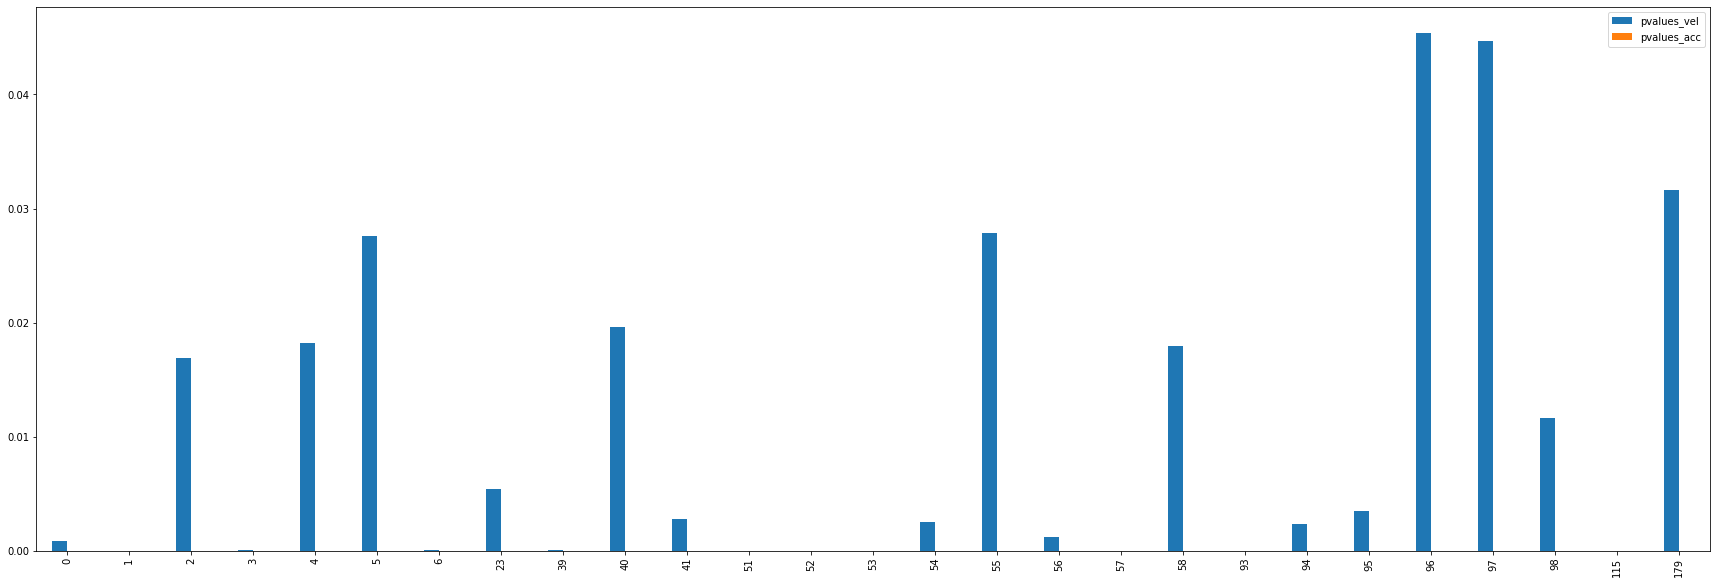

In [61]:
dfp = pd.DataFrame(data={'pvalues_vel':lt_vel, 'pvalues_acc':lt_acc}, index=trajs)
dfp[(dfp.pvalues_vel < 0.05)].plot(kind='bar', figsize=(30,10))
print()
print('Rejeitamos a hipótese de que estas trajetórias possuem a mediana de suas velocidades maior que a mediana de toda a amostra')
print()
print(dfp[(dfp.pvalues_vel < 0.05)].index)


## Testar detecção de outliers MEAN FILTER

In [125]:
df['MF_dist_from_old_point'] = df['dist_from_old_point'].rolling(5, min_periods=1).mean()
df['MDF_dist_from_old_point'] = df['dist_from_old_point'].rolling(5, min_periods=1).median()

In [145]:
df['MF_vel'] = 0
df['MF_vel'] = df['MF_dist_from_old_point'] / df['time_from_old_point']
df[df.MF_vel == np.inf].time_from_old_point.unique()

In [127]:
df['MDF_vel'] = 0
df['MDF_vel'] = df['MDF_dist_from_old_point'] / df['time_from_old_point']
df[df.MF_vel == np.inf].time_from_old_point.unique()

array([0.])

In [168]:
df.MF_vel = df.MF_vel.where(df.MF_vel != np.inf,0)
df.MDF_vel = df.MDF_vel.where(df.MDF_vel != np.inf,0)
df['MF_acc'] = df['MF_vel'] * (1/df['time_from_old_point'])
df['MDF_acc'] = df['MDF_vel'] * (1/df['time_from_old_point'])
df.MF_acc = df.MF_acc.where(df.MF_acc != np.inf,0)
df.MDF_acc = df.MDF_acc.where(df.MDF_acc != np.inf,0)
df['MF_acc'].fillna(0, inplace=True)
df['MDF_acc'].fillna(0, inplace=True)
df['MF_vel'].fillna(0, inplace=True)
df['MDF_vel'].fillna(0, inplace=True)

In [169]:
df[df.MDF_vel.isna()]

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point,datetime,hour,day,ID,outlier,outlier_norm,outlier2,outlier2_norm,MF_dist_from_old_position,MF_dist_from_old_point,MF_vel,outlier_MF,MDF_dist_from_old_point,MDF_vel,MF_acc,MDF_acc


<AxesSubplot:>

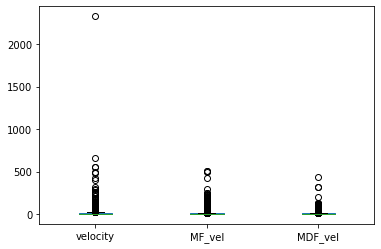

In [173]:
df[['velocity', 'MF_vel', 'MDF_vel']].plot(kind='box')

In [174]:
feats = ['velocity','acc']
feats_MF = ['MF_vel', 'MF_acc']
feats_MDF = ['MDF_vel', 'MDF_acc']

In [175]:
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[feats_MF])
scores = clf.predict(df[feats_MF])
df['outlier_MF'] = scores

In [179]:
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[feats])
scores = clf.predict(df[feats])
df['outlier_MDF'] = scores

<AxesSubplot:>

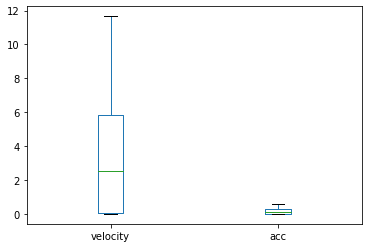

In [182]:
df[df.outlier== 1][feats].plot(kind='box')

<AxesSubplot:>

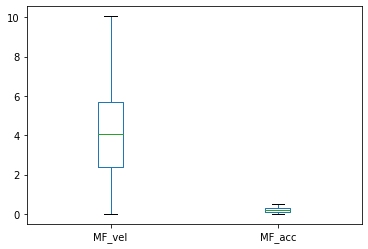

In [183]:
df[df.outlier_MF== 1][feats_MF].plot(kind='box')

<AxesSubplot:>

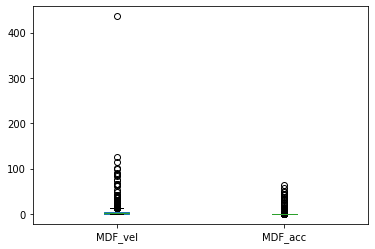

In [184]:
df[df.outlier_MDF== 1][feats_MDF].plot(kind='box')

timestamp                            object
line_id                              string
journey_id                           string
time_frame                           string
vehicle_journey_id                   string
operator                             string
congestion                           object
lng                                  object
lat                                  object
delay                                object
block_id                           category
vehicle_id                           string
stop_id                            category
stop                                   bool
velocity                            float64
acc                                 float64
dist_from_old_point                 float64
time_from_old_point                 float64
datetime                     datetime64[ns]
hour                                  int64
day                                   int64
ID                                    int16
outlier                         

In [190]:
data_line = df[df.ID == 49]

def to_mercator(Coords):
    Coordinates =  Coords
    #literal_eval(Coords)        
    lat = Coordinates[1]
    lon = Coordinates[0]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale    
    
    return pd.Series((x, y))

def plot_fig(df_x, color):
    p = figure(x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(get_provider(tile_provider))
    #p.circle(
    p.line(
        x='lng_m',
        y='lat_m',
        color= color,
        source=df_x
    )
    p.circle(
        x='lng_m',
        y='lat_m',
        color= 'red',
        source=df_x[df_x.outlier == -1]
    )
    p.circle(
        x=df_x.iloc[0]['lng_m'],
        y=df_x.iloc[0]['lat_m'],
        color= 'blue',    
    )
    return (p)


p = figure(x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(get_provider(tile_provider))

data_line[['lng_m','lat_m']] = data_line[['lng', 'lat']].apply(to_mercator, axis=1)

p = plot_fig(data_line, 'black')

show(p)

<ipython-input-190-2df71206eb0f>:11: RuntimeWarning: invalid value encountered in double_scalars
  scale = x/lon
/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


ValueError: Out of range float values are not JSON compliant